In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
weather_data=pd.read_csv("E:\DataScience\Kaggle\Machine Learning\Weather_data.csv")

# Function for Weather_Data analysis

In [3]:
def dataCleaning(dataset):
    weather_data=dataset
    weather_data.columns = weather_data.columns.str.strip().str.lower().str.replace('_', '') 
    print("Shape of the Weather Data ", weather_data.shape)
    print("///////Percentage of missing data before Missing Data Analysis //////////")
    print(100*(weather_data.isna().sum())/len(weather_data))
    for column in weather_data.columns:
        if ((100*(weather_data[column].isna().sum())/len(weather_data[column]))>70):
            weather_data=weather_data.drop([column], axis=1)
        else:
            # Lets Split the Categorical Features and Continuous Features
            cont_feature=[x for x in weather_data.select_dtypes(exclude=['object']).columns]
            catg_feature=[x for x in weather_data.select_dtypes(include=['object']).columns]
            # Filling the continuous fetures with median values
            for col in cont_feature:
                weather_data[col]=weather_data[col].fillna(weather_data[col].median())
            for col in catg_feature:
                weather_data[col]=weather_data[col].fillna(method ='ffill')
    print("////////Percentage of missing data is after Missing Value Treatment////////// ")
    print(100*(weather_data.isna().sum())/len(weather_data))
    
    def formatdate(dataset):
        dataset[['date','hour']] = dataset.datetimeutc.str.split("-",expand=True) 
        dataset[['hour','min']] = dataset.hour.str.split(":",expand=True) 
        years=[]
        months=[]
        days=[]
        def sepDate(date):
            date=str(date)
            years.append(date[:4])
            months.append(date[4:6])
            days.append(date[6:])
        dates=dataset.date.values
        for date in dates:
            sepDate(date)
        dataset['year']=years
        dataset['day']=days
        dataset['month']=months
        dataset=dataset.drop(['datetimeutc','date'], axis=1)
        return dataset
    
    weather_data=formatdate(weather_data)
    
    # Creating new Temp variables that fits the value previous 5 day value of temperature
    for obs in range(1,6):
        weather_data["Temp_" + str(obs)] = weather_data.tempm.shift(obs)
        weather_data["Temp_" + str(obs)].fillna(0.00,inplace=True)
    
    catg_feature=[x for x in weather_data.select_dtypes(include=['object']).columns]
    from sklearn.preprocessing import LabelEncoder
    
    
    lableEnc=LabelEncoder()
    for column in catg_feature:
        weather_data[column]=lableEnc.fit_transform(weather_data[column])
    # Outlier Analysis
    # Lets Split the Categorical Features and Continuous Features
    cont_feature=[x for x in weather_data.select_dtypes(exclude=['object']).columns]
    catg_feature=[x for x in weather_data.select_dtypes(include=['object']).columns]  
    # Outlier Analysis
    print("Box plot before outlier Analysis : ")
    import seaborn as sns
    for column in weather_data.columns:
        sns.boxplot(x=weather_data[column])
        plt.show()
    i=0
    while(i==2):
        Q1=data.quantile(0.25)
        Q3=data.quantile(0.75)
        IQR = Q3 - Q1
        print(IQR)
        weather_data = weather_data[~((weather_data < (Q1 - 1.5 * IQR)) |(weather_data > (Q3 + 1.5 * IQR))).any(axis=1)]
        i=i+1
    return weather_data


In [4]:
def weatherAnalysis(dataset):
    from sklearn.preprocessing import MinMaxScaler
    def minmaxSac(dataset):
        sc = MinMaxScaler()
        dataset = sc.fit_transform(dataset)
        return dataset
    target=dataset['tempm']
    features=dataset.drop(['tempm'], axis=1)
    final_features=minmaxSac(features)  
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=1)
    
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    
    
    # Random Forest Classifier
    from sklearn.ensemble import RandomForestRegressor
    RFmodel = RandomForestRegressor(random_state=1)
    RFmodel.fit(X_train, y_train)
    y_pred_rf = RFmodel.predict(X_test)
    rms_RF = sqrt(mean_squared_error(y_pred_rf, y_test))
    print("Value of RMSE with Randon Forest Classifier : ",rms_RF)
    


In [5]:
def DeepAnalysis(dataset):
    
    # Min_Max Scaling
    from sklearn.preprocessing import MinMaxScaler
    def minmaxSac(dataset):
        sc = MinMaxScaler()
        dataset = sc.fit_transform(dataset)
        return dataset
    target=dataset['tempm']
    features=dataset.drop(['tempm'], axis=1)
    final_features=minmaxSac(features)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM

    model_k = Sequential()
    model_k.add(LSTM(1, input_shape=(1,X_train.shape[1])))
    model_k.add(Dense(1))
    model_k.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    X_t_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val_resaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    
    history = model_k.fit(X_t_reshaped, y_train, epochs=100, batch_size=100, validation_data=(X_val_resaped, y_val))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    X_te_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    predicted_vals = model_k.predict(X_te_reshaped)
    import math
    from sklearn.metrics import mean_squared_error
    
    rmse = math.sqrt(mean_squared_error(y_test, predicted_vals))
    print("RMSE value with Deep Learning ", rmse)
    
    

In [6]:
def AnalyzeData(dataset):
    
    dataset_clean=dataCleaning(dataset)
    
    weatherAnalysis(dataset_clean)
    
    DeepAnalysis(dataset_clean)
    


Shape of the Weather Data  (98913, 20)
///////Percentage of missing data before Missing Data Analysis //////////
datetimeutc      0.000000
conds            0.068747
dewptm           0.625802
fog              0.000000
hail             0.000000
heatindexm      70.569086
hum              0.761275
precipm        100.000000
pressurem        0.233539
rain             0.000000
snow             0.000000
tempm            0.676352
thunder          0.000000
tornado          0.000000
vism             4.464529
wdird           14.538028
wdire           14.538028
wgustm          98.925318
windchillm      99.420703
wspdm            2.378858
dtype: float64
////////Percentage of missing data is after Missing Value Treatment////////// 
datetimeutc    0.0
conds          0.0
dewptm         0.0
fog            0.0
hail           0.0
heatindexm     0.0
hum            0.0
pressurem      0.0
rain           0.0
snow           0.0
tempm          0.0
thunder        0.0
tornado        0.0
vism           0.0
wdird  

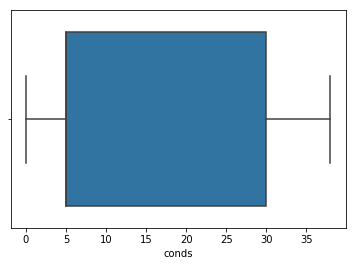

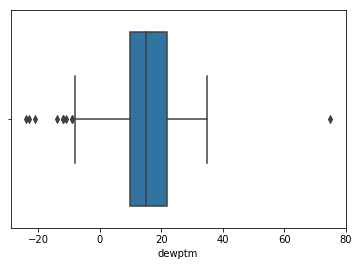

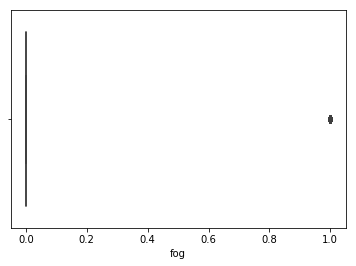

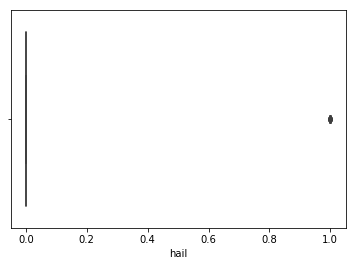

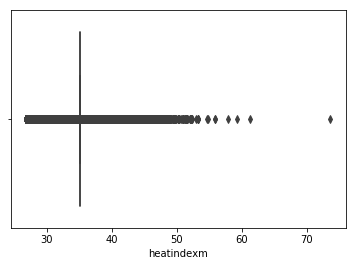

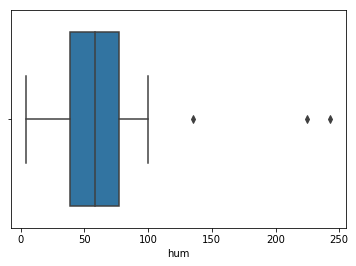

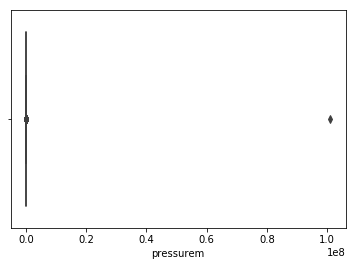

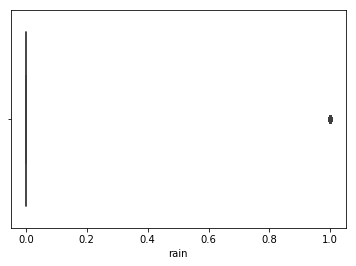

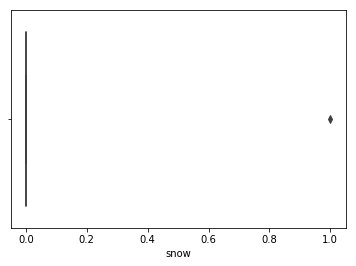

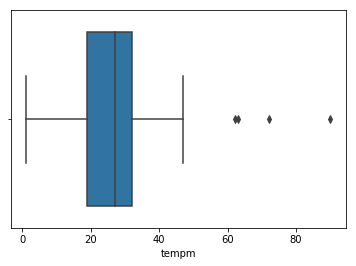

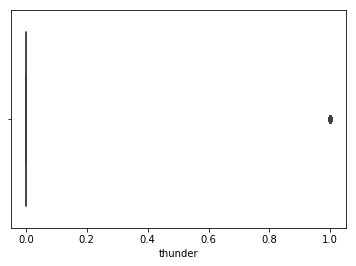

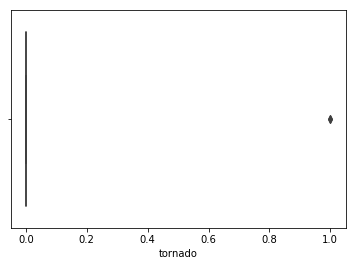

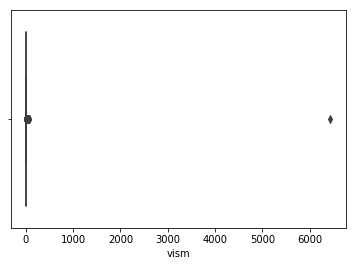

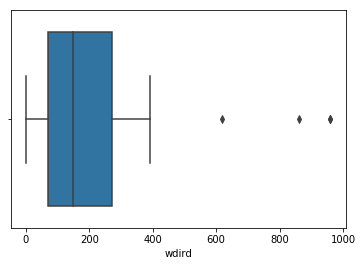

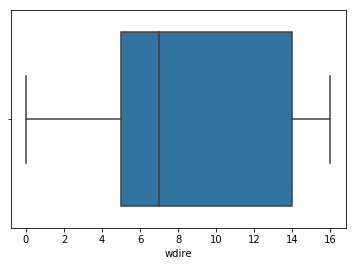

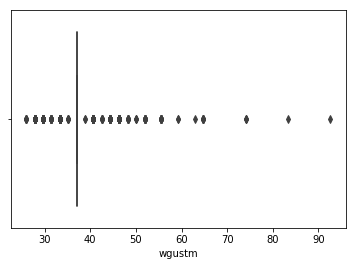

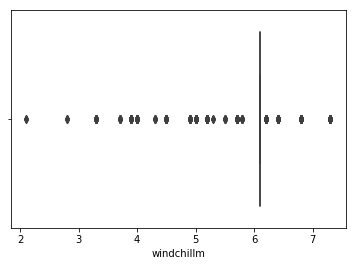

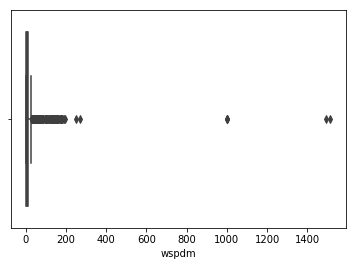

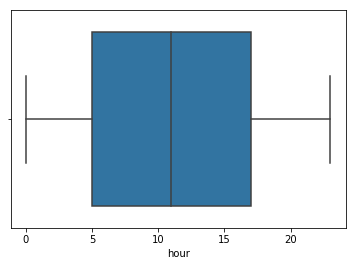

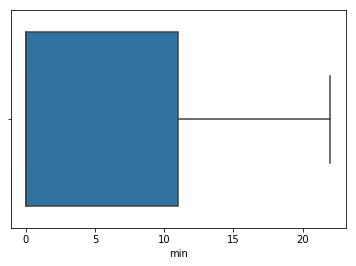

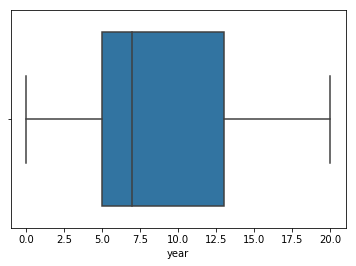

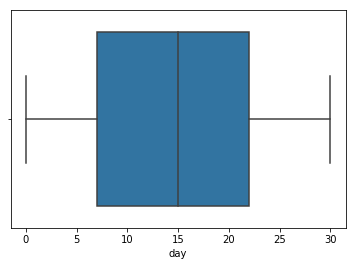

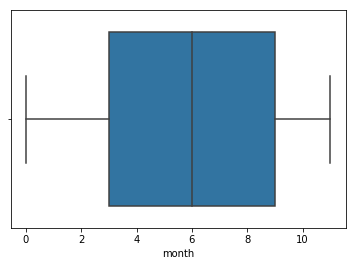

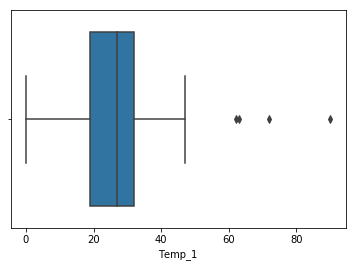

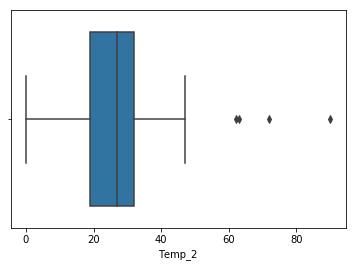

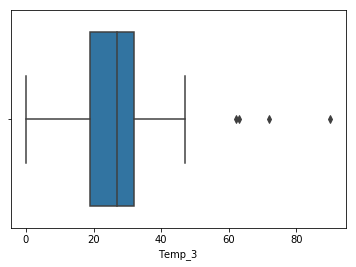

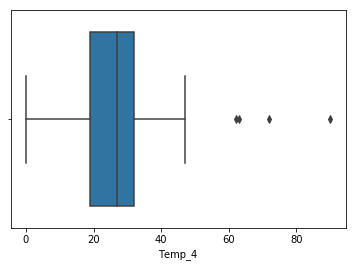

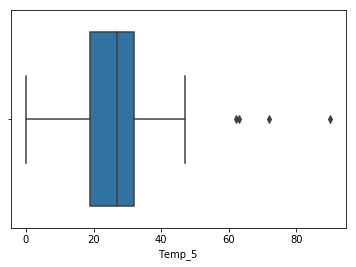

Value of RMSE with Randon Forest Classifier :  1.0198787458914338


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 63304 samples, validate on 15826 samples
Epoch 1/100
63304/63304 [==============================] - 10s 162us/step - loss: 657.2015 - acc: 0.0000e+00 - val_loss: 621.1758 - val_acc: 0.0000e+00
Epoch 2/100
63304/63304 [==============================] - 4s 56us/step - loss: 589.6756 - acc: 7.8984e-05 - val_loss: 569.2888 - val_acc: 1.8956e-04
Epoch 3/100
63304/63304 [==============================] - 4s 56us/step - loss: 540.6171 - acc: 3.3173e-04 - val_loss: 522.0700 - val_acc: 2.5275e-04
Epoch 4/100
63304/63304 [==============================] - 3s 55us/step - loss: 495.3307 - acc: 0.0015 - val_loss: 478.1017 - val_acc: 0.0022
Epoch 5/100
63304/63304 [==============================] - 3s 54us/step - loss: 453.0672 - acc: 0.0036 - val_loss: 436.9857 - val_acc: 0.0070
Epoch 6/100
63304/63304 [==============================] - 4s 56us/step - loss: 413.5058 - acc

63304/63304 [==============================] - 4s 58us/step - loss: 4.7769 - acc: 0.2915 - val_loss: 4.7704 - val_acc: 0.2917
Epoch 55/100
63304/63304 [==============================] - 4s 60us/step - loss: 4.5639 - acc: 0.2938 - val_loss: 4.5667 - val_acc: 0.2938
Epoch 56/100
63304/63304 [==============================] - 3s 49us/step - loss: 4.3688 - acc: 0.2963 - val_loss: 4.3911 - val_acc: 0.2939
Epoch 57/100
63304/63304 [==============================] - 3s 44us/step - loss: 4.1971 - acc: 0.2981 - val_loss: 4.2216 - val_acc: 0.2964
Epoch 58/100
63304/63304 [==============================] - 4s 65us/step - loss: 4.0393 - acc: 0.2999 - val_loss: 4.0745 - val_acc: 0.3032
Epoch 59/100
63304/63304 [==============================] - 4s 64us/step - loss: 3.8988 - acc: 0.3034 - val_loss: 3.9416 - val_acc: 0.2963
Epoch 60/100
63304/63304 [==============================] - 3s 51us/step - loss: 3.7746 - acc: 0.3045 - val_loss: 3.8206 - val_acc: 0.3006
Epoch 61/100
63304/63304 [==============

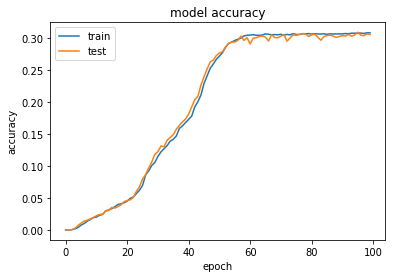

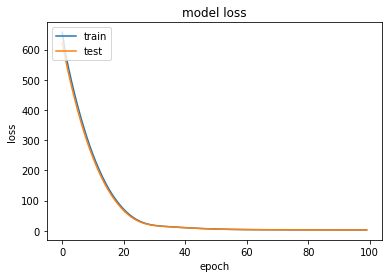

RMSE value with Deep Learning  1.676075424959491


In [7]:
AnalyzeData(weather_data) 